# Preparation and Data Loading

## Environment Setup

In [1]:
# Use this only for the final pdf generation
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import median_abs_deviation

In [3]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.3 anndata==0.10.9 umap==0.5.7 numpy==2.0.2 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.6 pynndescent==0.5.13


## Loading data

In [4]:
# Loading cell-gene matrices:
adata_10x = sc.read_10x_mtx('/home/juzis/Studijos/Thesis/data/downstream/matrices/PBMC_10x_2/10x/')
adata_final = sc.read_10x_mtx('/home/juzis/Studijos/Thesis/data/downstream/matrices/PBMC_10x_2/final/')

In [5]:
print(adata_10x.X.sum())
print(adata_final.X.sum())
print(adata_final.X[:, adata_final.var_names.str.startswith("INTERGENIC")].sum())

146862880.0
154398260.0
3128447.0


In [6]:
adata_10x.var_names_make_unique()
adata_final.var_names_make_unique()
print(adata_10x)
print(adata_final)

AnnData object with n_obs × n_vars = 6794880 × 38593
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 4243671 × 42005
    var: 'gene_ids', 'feature_types'


In [7]:
adata_final.raw = adata_final.copy()

# Quality control

Firstly let's compute various metrics, which we will later use

In [8]:
# Geting various metrics, including amount mitochondrial, ribosomal and hemoglobin genes:
adata_10x.var['mt'] = adata_10x.var_names.str.startswith('MT')
adata_10x.var["ribo"] = adata_10x.var_names.str.startswith(("RPS", "RPL"))
adata_10x.var["hb"] = adata_10x.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(adata_10x, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=True, inplace=True)

adata_final.var['mt'] = adata_final.var_names.str.startswith('MT')
adata_final.var["ribo"] = adata_final.var_names.str.startswith(("RPS", "RPL"))
adata_final.var["hb"] = adata_final.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(adata_final, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=True, inplace=True)

## Filtering

Barcodes with very low counts may represent empty droplets, we need to filter them out.  
Let's visualize counts per cell and set tresholds to filter low quality cells:

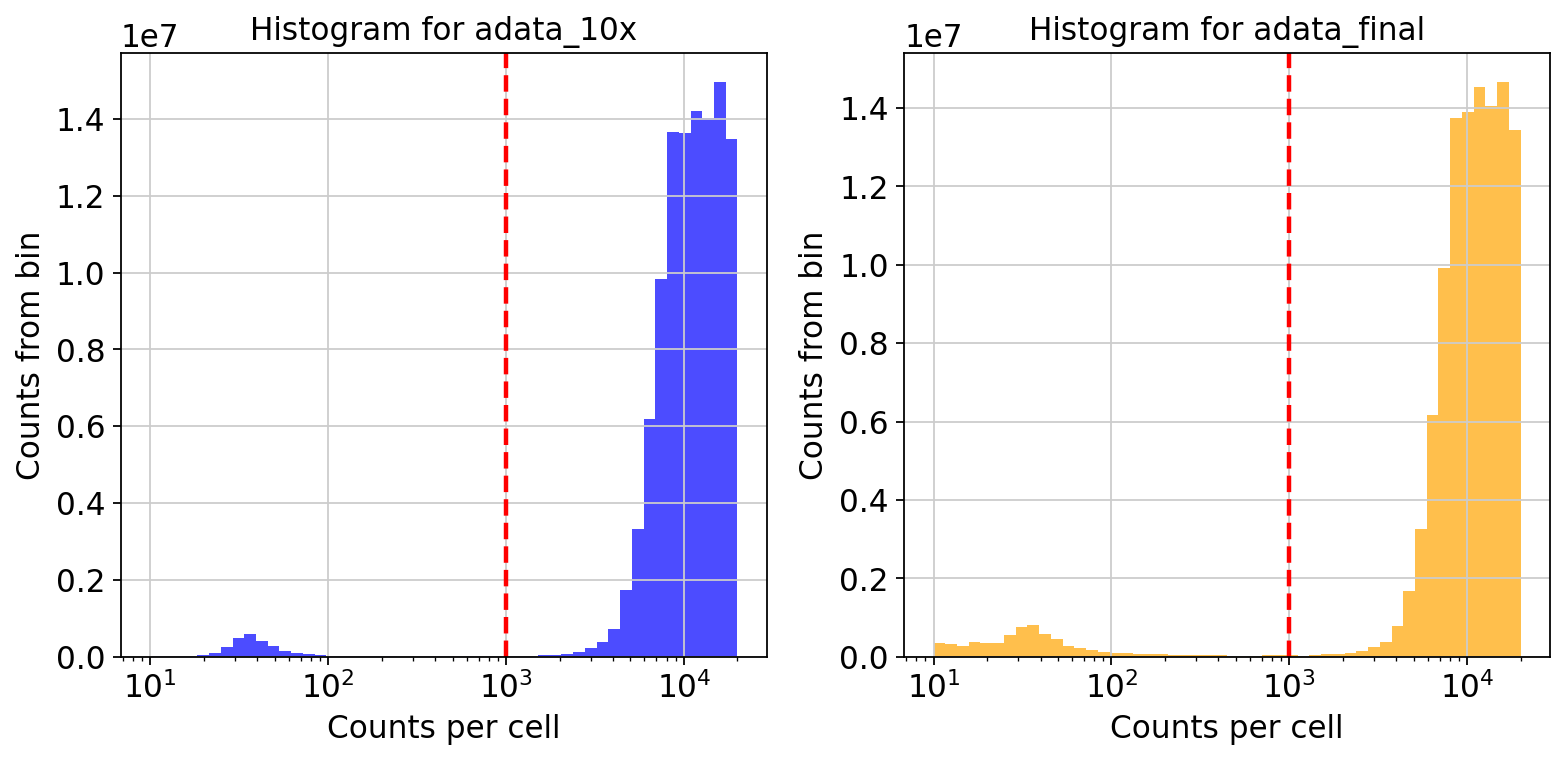

In [9]:
# Define bins
bins = np.logspace(np.log10(10), np.log10(20000), 51)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot: adata_10x
axs[0].hist(
    adata_10x.obs["total_counts"], bins=bins, weights=adata_10x.obs["total_counts"],
    color="blue", alpha=0.7
)
axs[0].set_xscale('log')
axs[0].set_ylabel("Counts from bin")
axs[0].set_xlabel("Counts per cell")
axs[0].set_title("Histogram for adata_10x")
axs[0].axvline(x=1000, color='red', linestyle='dashed', linewidth=2)

# Second subplot: adata_final
axs[1].hist(
    adata_final.obs["total_counts"], bins=bins, weights=adata_final.obs["total_counts"],
    color="orange", alpha=0.7
)
axs[1].set_xscale('log')
axs[1].set_ylabel("Counts from bin")
axs[1].set_xlabel("Counts per cell")
axs[1].set_title("Histogram for adata_final")
axs[1].axvline(x=1000, color='red', linestyle='dashed', linewidth=2)

# Adjust layout and display
plt.tight_layout()
plt.show()

So let's filter cells based on the above treshholds:

In [10]:
cmask = adata_10x.obs['total_counts'].values>1000
adata_10x = adata_10x[cmask]

cmask = adata_final.obs['total_counts'].values>1000
adata_final = adata_final[cmask]

Filtering low expression genes:

In [11]:
# Filtering low expression genes:
sc.pp.filter_genes(adata_10x, min_cells=3)
sc.pp.filter_genes(adata_final, min_cells=3)

In [12]:
print(adata_10x.shape)
print(adata_final.shape)

(11937, 29007)
(12032, 32927)


Let's filter low quality cells. We will use automatic thresholding via MAD (median absolute deviations). The MAD is given by $ MAD = median(|X_i - median(X)|) $, with $X_i$ being the respective QC metric of an observation and describes a robust statistic of the variability of the metric. I will mark cells as outliers if they differ by 5 MADs which is a relatively permissive filtering strategy.

In [13]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

We will use thresholds on "log1p_total_counts", "log1p_n_genes_by_counts" and "pct_counts_mt", as abnormalities in these metrics might correspond to dying cells (e.g. if a membrane of a cell is damaged, cytoplasmic RNA migth leak out, while mitochondrial RNA remains for longer time, resulting in high percentage of mitochondrial genes and low total counts). We apply stricter thresholds for mitochondrial genes.

In [14]:
adata_10x.obs["outlier"] = (
    is_outlier(adata_10x, "log1p_total_counts", 5)
    | is_outlier(adata_10x, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata_10x, "pct_counts_mt", 3)
    | (adata_10x.obs["pct_counts_mt"] > 10)
)

adata_final.obs["outlier"] = (
    is_outlier(adata_final, "log1p_total_counts", 5)
    | is_outlier(adata_final, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata_final, "pct_counts_mt", 3)
    | (adata_final.obs["pct_counts_mt"] > 10)
)

In [15]:
print(f"Total number of cells: {adata_10x.n_obs}")
adata_10x = adata_10x[(~adata_10x.obs.outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata_10x.n_obs}")

Total number of cells: 11937
Number of cells after filtering of low quality cells: 11135


In [16]:
print(f"Total number of cells: {adata_final.n_obs}")
adata_final = adata_final[(~adata_final.obs.outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata_final.n_obs}")

Total number of cells: 12032
Number of cells after filtering of low quality cells: 11199


## Doublets Detections

In some rare cases, we can have two cells in one droplet, leading to so called "doublets". To overcome this problem, we need to filter out those barcodes. We will use the method called Scrublet.

In [ ]:
sc.external.pp.scrublet(adata_10x)
sc.external.pp.scrublet(adata_final)

In [ ]:
cmask = adata_10x.obs['predicted_doublet'].values == False
adata_10x = adata_10x[cmask]

cmask = adata_final.obs['predicted_doublet'].values == False
adata_final = adata_final[cmask]

In [ ]:
print(adata_10x.shape)
print(adata_final.shape)

In [ ]:
adata_10x.layers["celltypist"] = adata_10x.X
adata_final.layers["celltypist"] = adata_final.X

In [ ]:
print(len([gene for gene in adata_final.var_names if gene.startswith("INTERGENIC")]))

## Visualisation

Plotting highest expression genes:

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sc.pl.highest_expr_genes(adata_10x, n_top=20, ax = axs[0], show = False)

sc.pl.highest_expr_genes(adata_final, n_top=20, ax = axs[1], show = False)

plt.tight_layout()
plt.show()

In [ ]:
sc.pl.violin(adata_10x, keys=['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'], jitter=0.4, multi_panel=True)
sc.pl.violin(adata_final, keys=['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'], jitter=0.4, multi_panel=True)

In [ ]:
figure, axs = plt.subplots(1,2, figsize=(12,5))

sc.pl.scatter(adata_10x, x='total_counts', y='pct_counts_mt', ax=axs[0], show=False)
sc.pl.scatter(adata_10x, x='total_counts', y='n_genes_by_counts', ax=axs[1], show=False)

plt.tight_layout()
plt.show()

figure, axs = plt.subplots(1,2, figsize=(12,5))

sc.pl.scatter(adata_final, x='total_counts', y='pct_counts_mt', ax=axs[0], show=False)
sc.pl.scatter(adata_final, x='total_counts', y='n_genes_by_counts', ax=axs[1], show=False)

plt.tight_layout()
plt.show()

# Normalization

Differences in count data between cells migth be the result due to sampling effects. Hence before proceeding with analysis, we need to normilize data. There are several normalization techniques (e.g. the shifted logarithm transformation, scran normalization and analytic approximation of Pearson residuals), each are well suited for different tasks. Here we will use shifted logarithm transformation, which works well for stabilizing variance for subsequent dimensionality reduction and identification of differentially expressed genes.

In [ ]:
print("Before normalization (adata_10x):")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(adata_10x.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Before normalization")

sc.pp.normalize_total(adata_10x, target_sum=None)
sc.pp.log1p(adata_10x)

sns.histplot(adata_10x.X.sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("After normalization (adata_10x)")

plt.tight_layout()
plt.show()

print("Before normalization (adata_final):")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(adata_final.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Before normalization")

sc.pp.normalize_total(adata_final, target_sum=None)
sc.pp.log1p(adata_final)

sns.histplot(adata_final.X.sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("After normalization (data_final)")

plt.tight_layout()
plt.show()

# Feature Selection

In [ ]:
sc.pp.highly_variable_genes(adata_10x, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata_final, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
sc.pl.highly_variable_genes(adata_10x)
sc.pl.highly_variable_genes(adata_final)

In [ ]:
# Setting this gene to highly variable to include it to further analysis
# adata.var.loc["INTERGENIC1", 'highly_variable'] = True

In [ ]:
adata_10x = adata_10x[:, adata_10x.var.highly_variable]
adata_final = adata_final[:, adata_final.var.highly_variable]

In [ ]:
print(adata_10x.shape)
print(adata_final.shape)

In [ ]:
print(len([gene for gene in adata_final.var_names if gene.startswith("INTERGENIC")]))

# Dimensionality reduction

## PCA

PCA is common strategy to construct the new set of variables with decreasing variance. In scRNA analysis, it is usually not used for clustering, instead, it is typically used to select the top 10-50 PCs which are used for downstream analysis tasks.

In [ ]:
sc.tl.pca(adata_10x, svd_solver='arpack')
sc.tl.pca(adata_final, svd_solver='arpack')

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (10,5))

sc.pl.pca(adata_10x, color='total_counts', show=False, ax = axs[0])
sc.pl.pca(adata_final, color='total_counts', show=False, ax = axs[1])

plt.tight_layout()
plt.show()

In [ ]:
sc.pl.pca_variance_ratio(adata_10x, log=True)
sc.pl.pca_variance_ratio(adata_final, log=True)

## t-SNE

t-SNE is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components.

In [ ]:
sc.tl.tsne(adata_10x, n_pcs = 8)
sc.tl.tsne(adata_final, n_pcs = 8)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

sc.pl.tsne(adata_10x, color="total_counts", show=False, ax=axs[0])
sc.pl.tsne(adata_final, color="total_counts", show=False, ax=axs[1])

plt.tight_layout()
plt.show()

## UMAP

UMAP is a graph based, non-linear dimensionality reduction technique and principally similar to t-SNE. To use UMAP, we firstly need to compute PCA and neighbours:

In [ ]:
sc.pp.neighbors(adata_10x, n_pcs = 8)
sc.tl.umap(adata_10x)

sc.pp.neighbors(adata_final, n_pcs = 8)
sc.tl.umap(adata_final)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))

sc.pl.umap(adata_10x, color="total_counts", show=False, ax = axs[0])
sc.pl.umap(adata_final, color="total_counts", show=False, ax = axs[1])

plt.tight_layout()
plt.show()

# Clustering

Now let's use some cluster algorithms to separate different (sub)types of cells. We can roughly see different groups visually in the graphs of reduced dimension above. However, using various developed algorithms is more precise way to do that. Here we will use Leiden algorithm.

In [ ]:
sc.tl.leiden(adata_10x, resolution=1, key_added="leiden1")
sc.tl.leiden(adata_10x, resolution=0.5, key_added="leiden05")
sc.tl.leiden(adata_10x, resolution=2, key_added="leiden2")

sc.tl.leiden(adata_final, resolution=1, key_added="leiden1")
sc.tl.leiden(adata_final, resolution=0.5, key_added="leiden05")
sc.tl.leiden(adata_final, resolution=2, key_added="leiden2")

In [ ]:
print("10x")
sc.pl.umap(adata_10x, color=['leiden1', 'leiden05', 'leiden2'])

In [ ]:
print("final")
sc.pl.umap(adata_final, color=['leiden1', 'leiden05', 'leiden2'])

# Annotation

## Automatic annotation

In [ ]:
import celltypist
from celltypist import models

In [ ]:
def CellTypist(adata):
    models.download_models(force_update=True, model=["Immune_All_Low.pkl", "Immune_All_High.pkl"])
    model_low = models.Model.load(model="Immune_All_Low.pkl")
    model_high = models.Model.load(model="Immune_All_High.pkl")
    
    adata_celltypist = adata.copy()
    adata_celltypist.X = adata.layers["celltypist"]
    sc.pp.normalize_total(adata_celltypist, target_sum = 10000)
    sc.pp.log1p(adata_celltypist)
    adata_celltypist.X = adata_celltypist.X.toarray()

    predictions_high = celltypist.annotate(adata_celltypist, model=model_high, majority_voting=True)
    predictions_high_adata = predictions_high.to_adata()
    adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
        adata.obs.index, "majority_voting"]
    adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
        adata.obs.index, "conf_score"]
    sc.pl.umap(adata,
        color=["celltypist_cell_label_coarse", "celltypist_conf_score_coarse"],
        frameon=False,
        sort_order=False,
        wspace=1,
        legend_loc = "on data")
    
    predictions_low = celltypist.annotate(adata_celltypist, model=model_low, majority_voting=True)
    predictions_low_adata = predictions_low.to_adata()
    adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[
        adata.obs.index, "majority_voting"]
    adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[
        adata.obs.index, "conf_score"]
    sc.pl.umap(adata,
        color=["celltypist_cell_label_fine", "celltypist_conf_score_fine"],
        frameon=False,
        sort_order=False,
        wspace=1)

In [ ]:
CellTypist(adata_10x)
CellTypist(adata_final)

# INTERGENIC

In [ ]:
# sc.pl.umap(adata_final, color=[gene for gene in adata_final.var_names if gene.startswith("INTERGENIC")], show=True)

sc.settings.figdir = "../../images/umap_images_intergenic_regions/PBMC_10x_2/highly_variable/"

for gene in [gene for gene in adata_final.var_names if gene.startswith("INTERGENIC")]:
    sc.pl.umap(adata_final, color=gene, save=f"{gene}.png", show=False)

In [ ]:
sc.settings.figdir = "../../images/umap_images_intergenic_regions/PBMC_10x_2/all/"

for gene in [gene for gene in adata_final.raw.var_names if gene.startswith("INTERGENIC")]:
    sc.pl.umap(adata_final, color=gene, use_raw = True, save=f"{gene}.png", show=False)

# INTERGENIC

## Loading data

In [ ]:
# Loading cell-gene matrices:
adata = sc.read_10x_mtx('/home/juzis/Studijos/Thesis/data/downstream/matrices/PBMC_10x_2/final/')

In [ ]:
adata = adata[:, adata.var_names.str.startswith("INTERGENIC")].copy()

In [ ]:
print(adata.X.sum())

In [ ]:
adata.var_names_make_unique()
print(adata)

# Quality control

Firstly let's compute various metrics, which we will later use

In [ ]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=True, inplace=True)

In [ ]:
print(adata)

## Filtering

Barcodes with very low counts may represent empty droplets, we need to filter them out.  
Let's visualize counts per cell and set tresholds to filter low quality cells:

In [ ]:
bins = np.logspace(np.log10(10),np.log10(20000),51)

# histograms:
plt.hist(adata.obs["total_counts"], bins = bins, weights = adata.obs["total_counts"])
plt.xscale('log')
plt.ylabel("counts from bin")
plt.xlabel("counts per cell")
plt.title("Histogram")

# tresholds (set manually):
plt.axvline(x=50, color='red', linestyle='dashed', linewidth=2)

plt.tight_layout()
plt.show()

So let's filter cells based on the above treshholds:

In [ ]:
cmask = adata.obs['total_counts'].values>50
adata = adata[cmask]

print(adata.shape)

Filtering low expression genes:

In [ ]:
# Filtering low expression genes:
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
print(adata.shape)

Let's filter low quality cells. We will use automatic thresholding via MAD (median absolute deviations). The MAD is given by $ MAD = median(|X_i - median(X)|) $, with $X_i$ being the respective QC metric of an observation and describes a robust statistic of the variability of the metric. I will mark cells as outliers if they differ by 5 MADs which is a relatively permissive filtering strategy.

In [ ]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

We will use thresholds on "log1p_total_counts", "log1p_n_genes_by_counts" and "pct_counts_mt", as abnormalities in these metrics might correspond to dying cells (e.g. if a membrane of a cell is damaged, cytoplasmic RNA migth leak out, while mitochondrial RNA remains for longer time, resulting in high percentage of mitochondrial genes and low total counts). We apply stricter thresholds for mitochondrial genes.

In [ ]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
)

In [ ]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

## Doublets Detections

In some rare cases, we can have two cells in one droplet, leading to so called "doublets". To overcome this problem, we need to filter out those barcodes. We will use the method called Scrublet.

In [ ]:
sc.external.pp.scrublet(adata)

In [ ]:
cmask = adata.obs['predicted_doublet'].values == False
adata = adata[cmask]

In [ ]:
print(adata.shape)

## Visualisation

Plotting highest expression genes:

In [ ]:
%matplotlib inline

sc.pl.highest_expr_genes(adata, n_top=20, show=True)

plt.tight_layout()
plt.show()

In [ ]:
sc.pl.violin(adata, keys=['total_counts'], jitter=0.4, multi_panel=True)

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', show=True)

# Normalization

Differences in count data between cells migth be the result due to sampling effects. Hence before proceeding with analysis, we need to normilize data. There are several normalization techniques (e.g. the shifted logarithm transformation, scran normalization and analytic approximation of Pearson residuals), each are well suited for different tasks. Here we will use shifted logarithm transformation, which works well for stabilizing variance for subsequent dimensionality reduction and identification of differentially expressed genes.

In [ ]:
print("Before normalization:")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Before normalization")

sc.pp.normalize_total(adata, target_sum=None)
sc.pp.log1p(adata)

sns.histplot(adata.X.sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("After normalization")

plt.tight_layout()
plt.show()

# Feature Selection

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata = adata[:, adata.var.highly_variable]

In [ ]:
print(adata.shape)

# Dimensionality reduction

## PCA

PCA is common strategy to construct the new set of variables with decreasing variance. In scRNA analysis, it is usually not used for clustering, instead, it is typically used to select the top 10-50 PCs which are used for downstream analysis tasks.

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pl.pca(adata, color='total_counts', show=True)

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

## t-SNE

t-SNE is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components.

In [ ]:
sc.tl.tsne(adata, n_pcs = 8)

In [ ]:
sc.pl.tsne(adata, color="total_counts", show=True)

## UMAP

UMAP is a graph based, non-linear dimensionality reduction technique and principally similar to t-SNE. To use UMAP, we firstly need to compute PCA and neighbours:

In [ ]:
sc.pp.neighbors(adata, n_pcs = 8)
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color="total_counts", show=True)

In [ ]:
adata.obs['celltypist_cell_label_coarse'] = adata_10x.obs['celltypist_cell_label_coarse'].reindex(adata.obs_names)
adata = adata[~adata.obs['celltypist_cell_label_coarse'].isna()].copy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(adata, color='celltypist_cell_label_coarse', title='Intergenic', show=False, ax=axes[0], legend_loc = None)
sc.pl.umap(adata_10x, color='celltypist_cell_label_coarse', title='10x', show=False, ax=axes[1])

plt.tight_layout()
plt.savefig("../../images/umaps/intergenic_10x_indrops.png", dpi = 300)
plt.show()

In [ ]:
adata.obs['celltypist_cell_label_coarse'] = adata_10x.obs['celltypist_cell_label_coarse'].reindex(adata.obs_names)
adata = adata[~adata.obs['celltypist_cell_label_coarse'].isna()].copy()

adata_10x.obs['celltypist_cell_label_coarse'] = adata_10x.obs['celltypist_cell_label_coarse'].cat.set_categories(adata.obs['celltypist_cell_label_coarse'].cat.categories)
adata.uns['celltypist_cell_label_coarse_colors'] = adata_10x.uns['celltypist_cell_label_coarse_colors']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sc.pl.umap(adata, color='celltypist_cell_label_coarse', title='Intergenic', show=False, ax=axes[0], legend_loc=None)
sc.pl.umap(adata_10x, color='celltypist_cell_label_coarse', title='10x', show=False, ax=axes[1], legend_loc=None)

# Create a custom legend
import matplotlib.patches as mpatches
colors = adata_10x.uns['celltypist_cell_label_coarse_colors']  # Assuming the colors are stored here
labels = adata_10x.obs['celltypist_cell_label_coarse'].cat.categories
legend_patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(labels)]

# Add the legend below both subplots
fig.legend(handles=legend_patches, loc='lower center', ncol=len(labels), frameon=False)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space for the legend
plt.savefig("../../images/umaps/intergenic_10x_pbmc10x2.png", dpi=300)
plt.show()

In [ ]:
adata.obs['celltypist_cell_label_fine'] = adata_10x.obs['celltypist_cell_label_fine'].reindex(adata.obs_names)
adata = adata[~adata.obs['celltypist_cell_label_fine'].isna()].copy()

adata_10x.obs['celltypist_cell_label_fine'] = adata_10x.obs['celltypist_cell_label_fine'].cat.set_categories(adata.obs['celltypist_cell_label_fine'].cat.categories)
adata.uns['celltypist_cell_label_fine_colors'] = adata_10x.uns['celltypist_cell_label_fine_colors']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sc.pl.umap(adata, color='celltypist_cell_label_fine', title='Intergenic', show=False, ax=axes[0], legend_loc=None)
sc.pl.umap(adata_10x, color='celltypist_cell_label_fine', title='10x', show=False, ax=axes[1], legend_loc=None)

# Create a custom legend
import matplotlib.patches as mpatches
colors = adata_10x.uns['celltypist_cell_label_fine_colors']  # Assuming the colors are stored here
labels = adata_10x.obs['celltypist_cell_label_fine'].cat.categories
legend_patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(labels)]

# Add the legend below both subplots
fig.legend(handles=legend_patches, ncols = 4, loc='lower center', ncol=len(labels), frameon=False)

plt.tight_layout(rect=[0, 0.2, 1, 1])  # Leave space for the legend
plt.savefig("../../images/umaps/intergenic_10x_pbmc10x2_fine_clusters.png", dpi=300)
plt.show()

# Checking PCAs

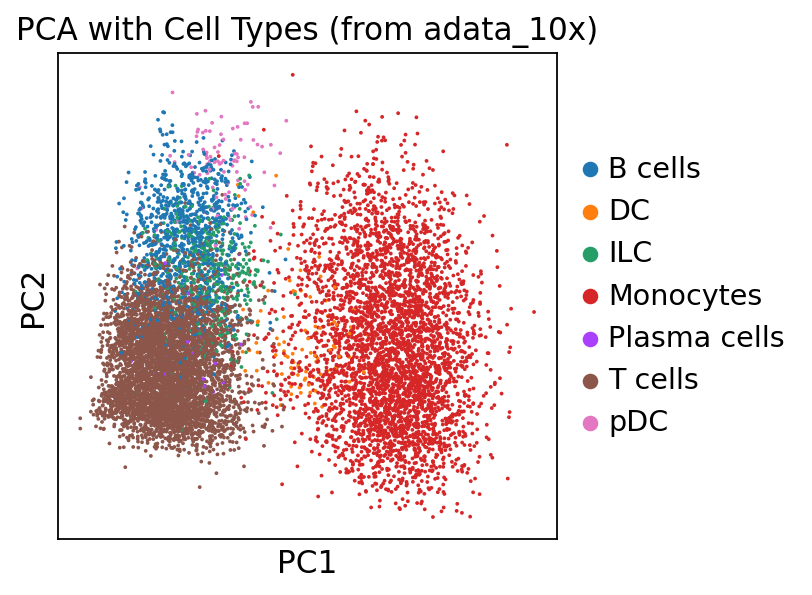

In [79]:
sc.pl.pca(adata, color='celltypist_cell_label_coarse', title='PCA with Cell Types (from adata_10x)')

In [80]:
# Loadings for all PCs
loadings = adata.varm['PCs']

# Loadings for PC1 and PC2
pc1_loadings = loadings[:, 0]  # First PC
pc2_loadings = loadings[:, 1]  # Second PC

In [81]:
top_genes_pc1 = adata.var_names[np.argsort(-np.abs(pc1_loadings))[:10]]  # Top 10 genes
print("Top genes for PC1:", top_genes_pc1)

Top genes for PC1: Index(['INTERGENIC2785', 'INTERGENIC2566', 'INTERGENIC3203', 'INTERGENIC917',
       'INTERGENIC50', 'INTERGENIC1137', 'INTERGENIC2226', 'INTERGENIC2191',
       'INTERGENIC1565', 'INTERGENIC2535'],
      dtype='object')


In [82]:
top_genes_pc2 = adata.var_names[np.argsort(-np.abs(pc2_loadings))[:10]]  # Top 10 genes
print("Top genes for PC2:", top_genes_pc2)

Top genes for PC2: Index(['INTERGENIC2336', 'INTERGENIC1661', 'INTERGENIC2535', 'INTERGENIC2566',
       'INTERGENIC1334', 'INTERGENIC2785', 'INTERGENIC2191', 'INTERGENIC3203',
       'INTERGENIC2356', 'INTERGENIC1565'],
      dtype='object')


In [83]:
# PCA scores for all cells
pca_scores = adata.obsm['X_pca']

# Scores for PC1 and PC2
pc1_scores = pca_scores[:, 0]
pc2_scores = pca_scores[:, 1]

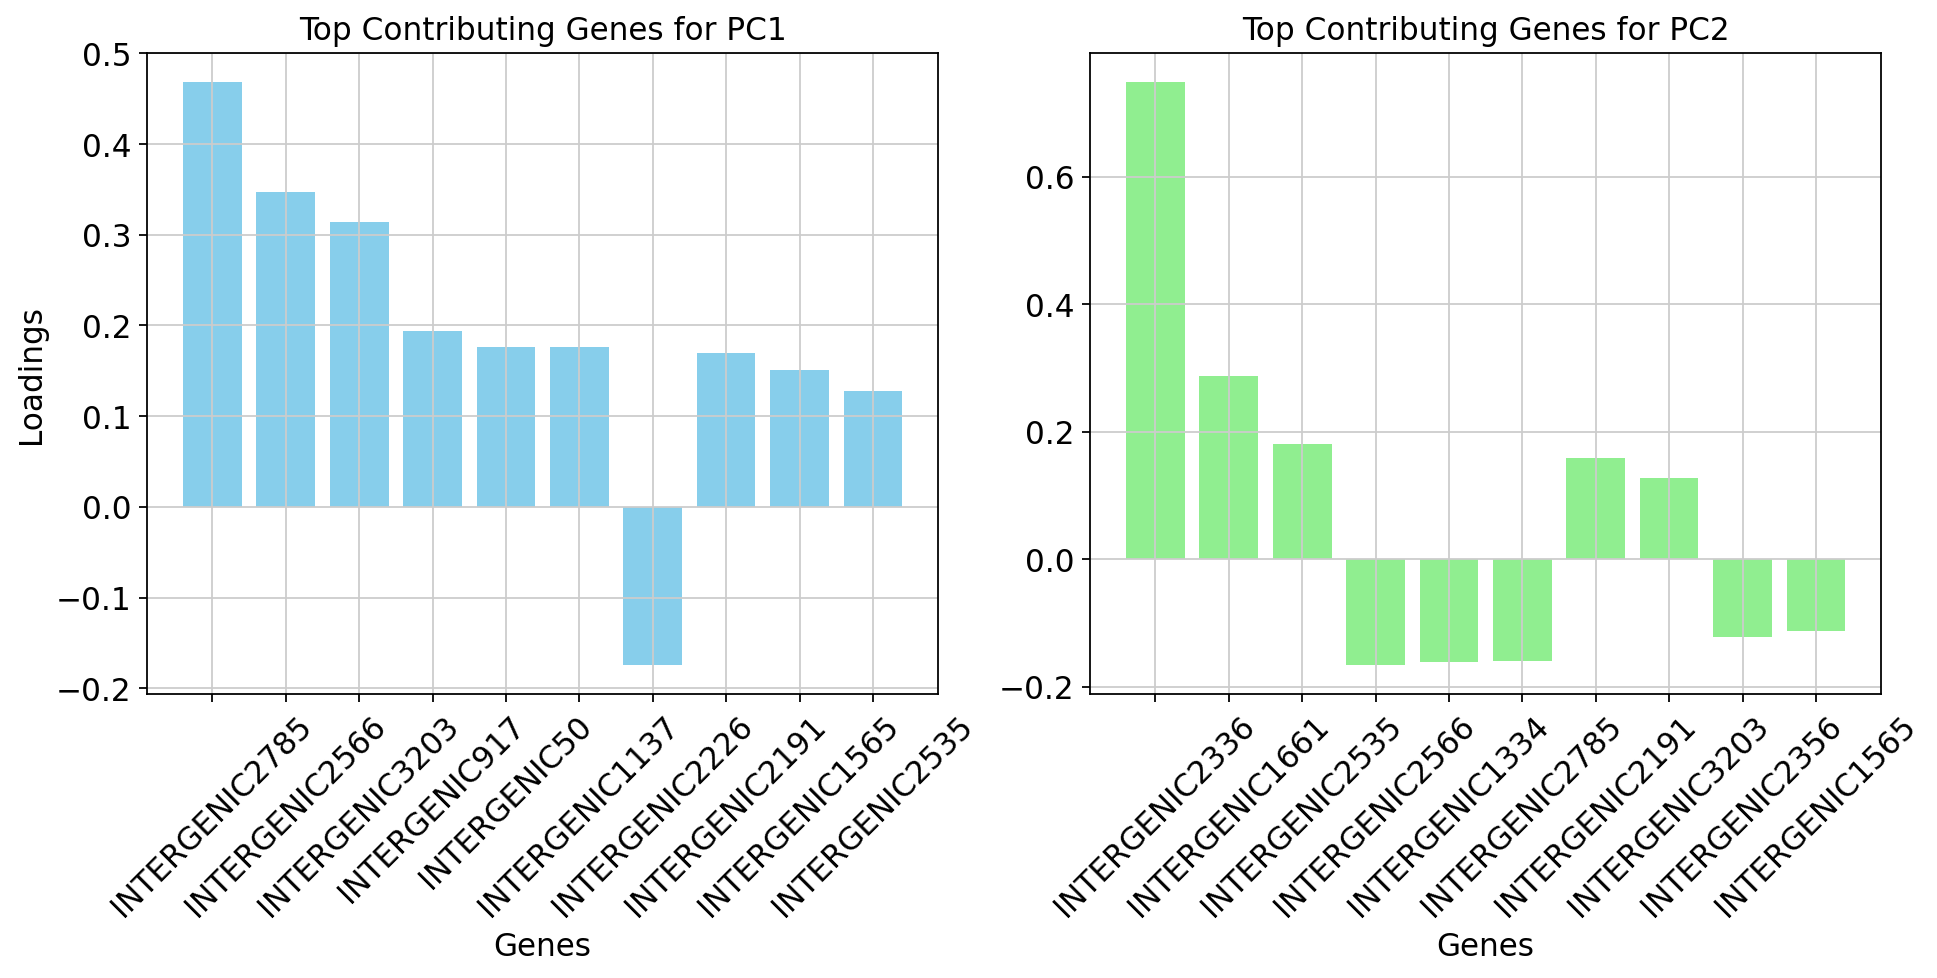

In [84]:
top_n = 10

# Get loadings for PC1 and PC2
pc1_loadings = adata.varm['PCs'][:, 0]  # PC1
pc2_loadings = adata.varm['PCs'][:, 1]  # PC2

# Get top genes for PC1 and PC2
top_genes_pc1 = adata.var_names[np.argsort(-np.abs(pc1_loadings))[:top_n]]
top_genes_pc2 = adata.var_names[np.argsort(-np.abs(pc2_loadings))[:top_n]]

# Get corresponding loadings
top_loadings_pc1 = pc1_loadings[np.argsort(-np.abs(pc1_loadings))[:top_n]]
top_loadings_pc2 = pc2_loadings[np.argsort(-np.abs(pc2_loadings))[:top_n]]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Plot PC1
axes[0].bar(top_genes_pc1, top_loadings_pc1, color='skyblue')
axes[0].set_title("Top Contributing Genes for PC1")
axes[0].set_xlabel("Genes")
axes[0].set_ylabel("Loadings")
axes[0].tick_params(axis='x', rotation=45)

# Plot PC2
axes[1].bar(top_genes_pc2, top_loadings_pc2, color='lightgreen')
axes[1].set_title("Top Contributing Genes for PC2")
axes[1].set_xlabel("Genes")
axes[1].tick_params(axis='x', rotation=45)

# Show the plots
plt.show()

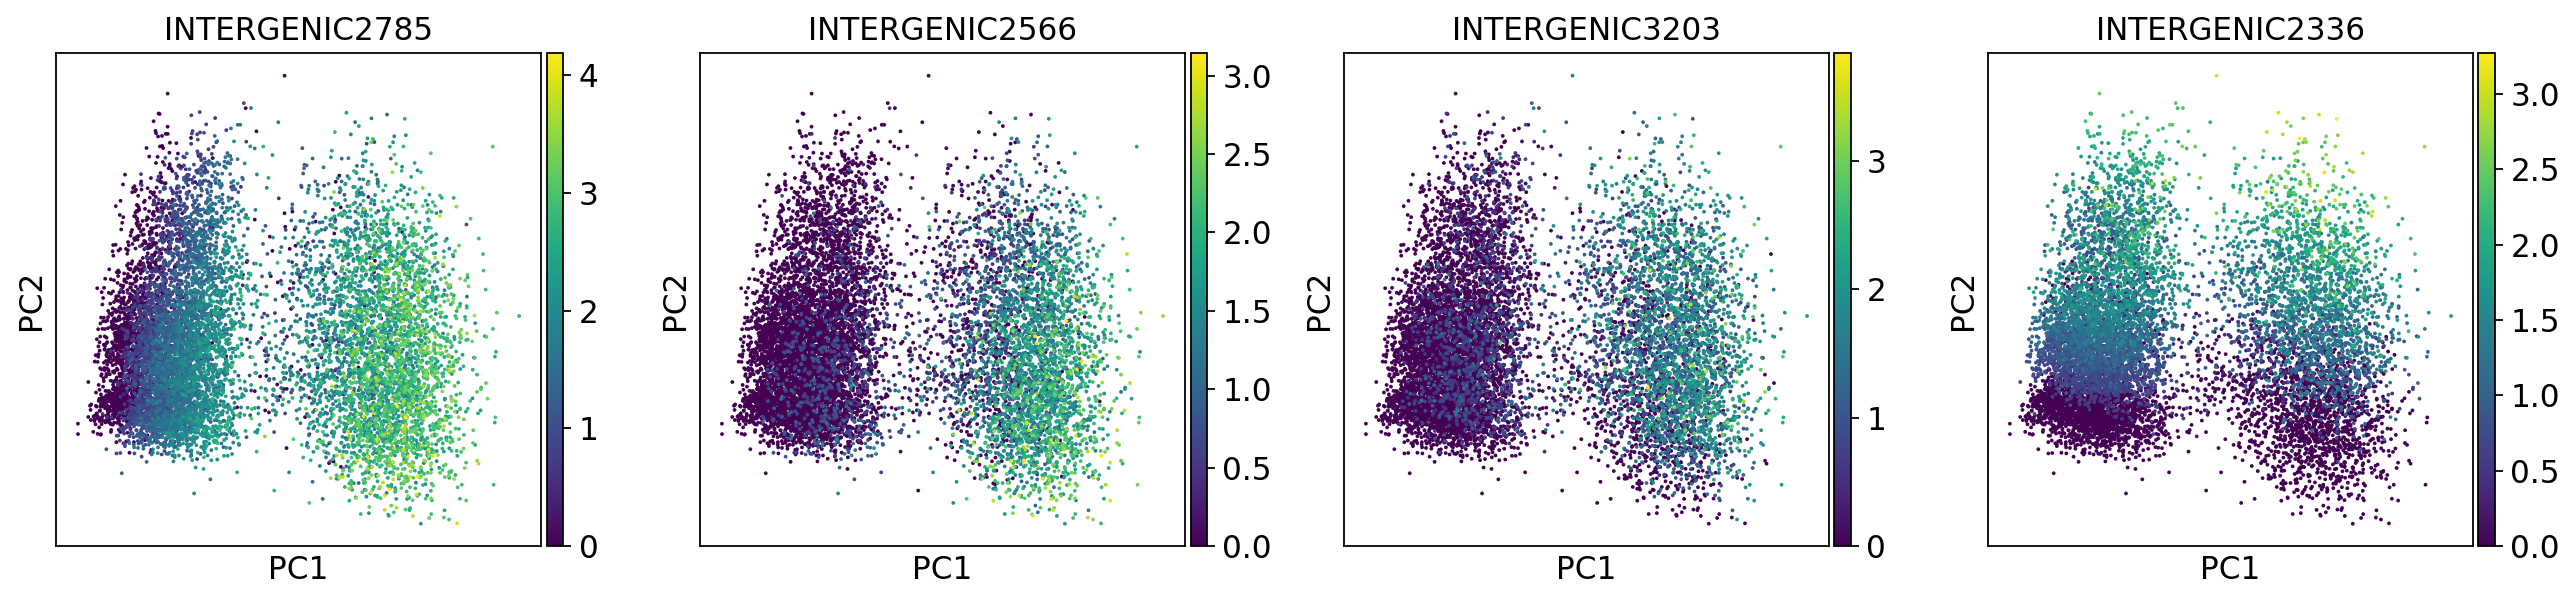

In [87]:
sc.pl.pca(adata, color = ['INTERGENIC2785', 'INTERGENIC2566', 'INTERGENIC3203', 'INTERGENIC2336'], show = True)

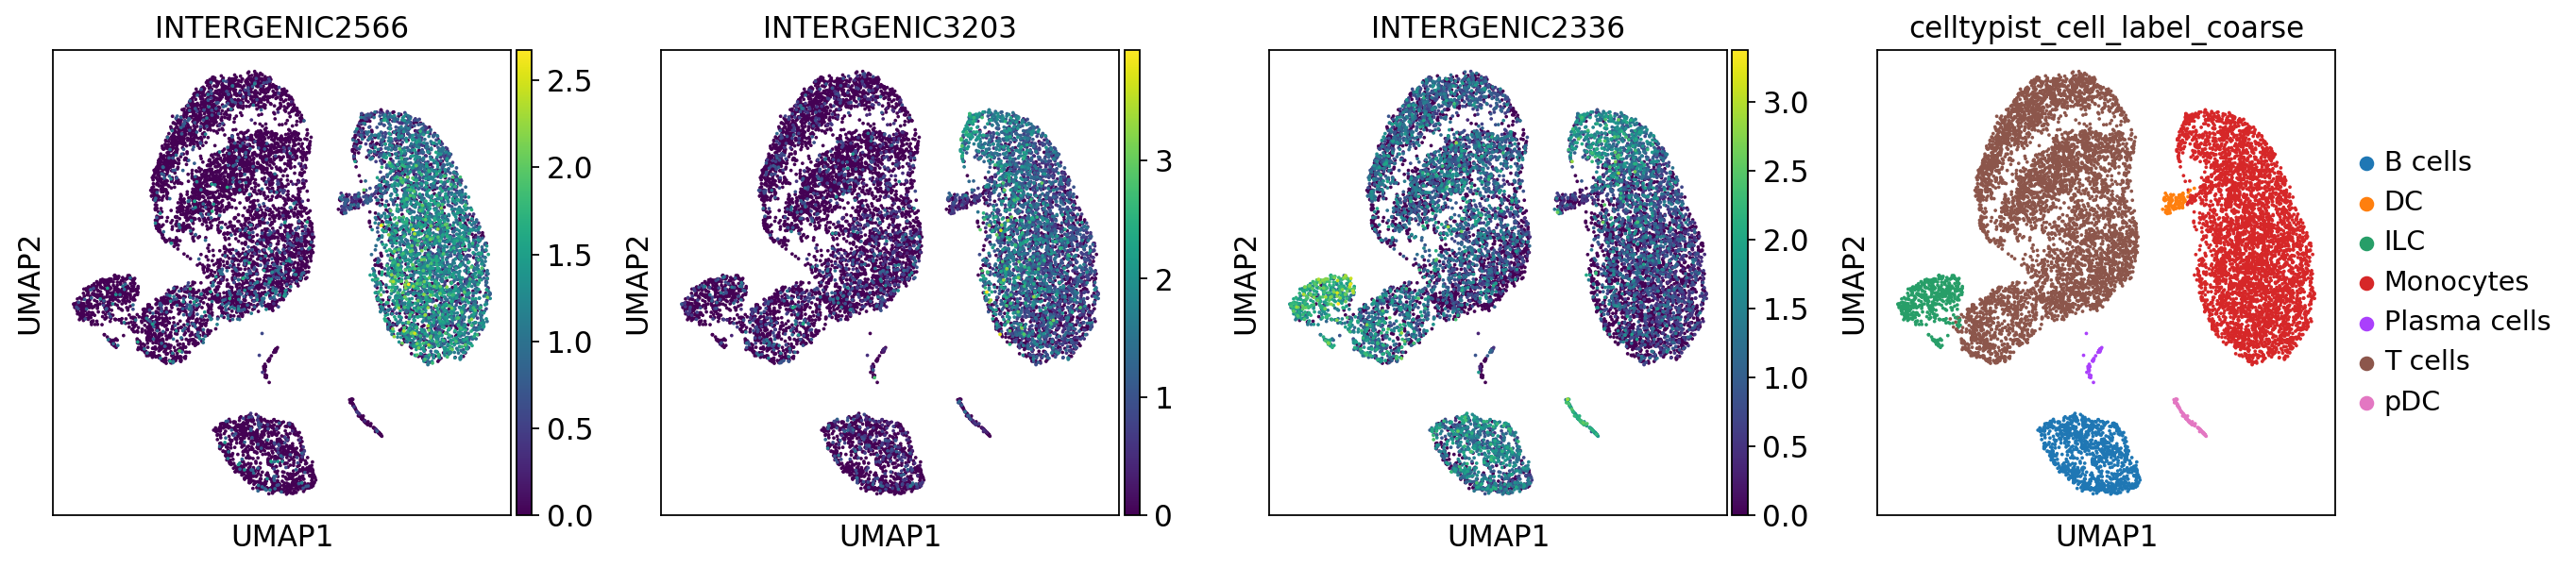

In [90]:
sc.pl.umap(adata_final, color = ['INTERGENIC2566', 'INTERGENIC3203', 'INTERGENIC2336', 'celltypist_cell_label_coarse'], show = True)

# Checking

In [128]:
all_genes = np.union1d(adata_10x.var_names, adata_final.var_names)

In [129]:
print(len(adata_10x.var_names))
print(len(adata_final.var_names))
print(len(all_genes))

4268
4763
4908


In [130]:
adata_10x[1,:10].var

,gene_ids,feature_types,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
LINC01409,ENSG00000237491,Gene Expression,False,False,False,1422,0.000290,0.000290,99.979072,1969.0,7.585789,1364,True,0.115472,0.456352,0.504227
HES4,ENSG00000188290,Gene Expression,False,False,False,948,0.000323,0.000323,99.986048,2192.0,7.693026,809,True,0.062937,0.849655,1.629289
ISG15,ENSG00000187608,Gene Expression,False,False,False,8028,0.004637,0.004627,99.881852,31511.0,10.358124,6813,True,1.024823,1.730888,1.851027
C1orf159,ENSG00000131591,Gene Expression,False,False,False,1662,0.000360,0.000360,99.975540,2448.0,7.803435,1608,True,0.145883,0.516650,0.676711
TNFRSF18,ENSG00000186891,Gene Expression,False,False,False,528,0.000122,0.000122,99.992229,831.0,6.723833,487,True,0.072072,1.093124,2.325743
TNFRSF4,ENSG00000186827,Gene Expression,False,False,False,634,0.000157,0.000157,99.990669,1070.0,6.976348,553,True,0.081950,1.093948,2.328102
MIB2,ENSG00000197530,Gene Expression,False,False,False,1978,0.000364,0.000364,99.970890,2476.0,7.814804,1803,True,0.175710,0.539518,0.742128
MMP23B,ENSG00000189409,Gene Expression,False,False,False,383,0.000066,0.000066,99.994363,447.0,6.104793,357,True,0.038467,0.633514,1.011008
PLCH2,ENSG00000149527,Gene Expression,False,False,False,290,0.000047,0.000047,99.995732,320.0,5.771441,265,True,0.026903,0.512983,0.666222
ENSG00000236948,ENSG00000236948,Gene Expression,False,False,False,191,0.000056,0.000056,99.997189,378.0,5.937536,182,True,0.031235,1.245013,2.760229


In [131]:
# Step 1: Align gene sets by combining the genes in both datasets
# Add missing genes with zero expression in both datasets
all_genes = np.intersect1d(adata_10x.var_names, adata_final.var_names)

# Reindex both adatas to ensure they have the same genes
adata_10x = adata_10x[:, all_genes].copy()
adata_final = adata_final[:, all_genes].copy()

# Step 2: Replace NaN values (for genes not present in one dataset) with zeros
adata_10x.X = np.nan_to_num(adata_10x.X)  # Assuming 'raw' contains the data to compare
adata_final.X = np.nan_to_num(adata_final.X)

# Step 3: Calculate total counts per gene in both datasets
total_counts_10x = np.array(adata_10x.X.sum(axis=0)).flatten()
total_counts_final = np.array(adata_final.X.sum(axis=0)).flatten()

# Step 4: Calculate the difference in gene counts (final - 10x)
gene_comparison = pd.DataFrame({
    'gene': all_genes,
    'total_counts_adata_10x': total_counts_10x,
    'total_counts_adata_final': total_counts_final,
    'count_difference': total_counts_final - total_counts_10x  # Calculate difference
})

# Step 5: Sort by the count difference to find the most different genes
gene_comparison_sorted = gene_comparison.sort_values(by='count_difference', ascending=False)

# Display the comparison
# Print the first few rows (head) and last few rows (tail) of the specified columns
print(gene_comparison_sorted[['gene', 'total_counts_adata_10x', 'total_counts_adata_final', 'count_difference']].head())
print(gene_comparison_sorted[['gene', 'total_counts_adata_10x', 'total_counts_adata_final', 'count_difference']].tail())


        gene  total_counts_adata_10x  total_counts_adata_final  \
3857    TYMP             3901.285400              12160.720703   
3478  SPECC1             2872.678955               4860.838867   
3780   TRBC1             5463.832520               6833.428711   
1565  FCGR2C             1552.903076               2873.223633   
2860   PILRA             3568.148926               4868.467285   

      count_difference  
3857       8259.435547  
3478       1988.159912  
3780       1369.596191  
1565       1320.320557  
2860       1300.318359  
        gene  total_counts_adata_10x  total_counts_adata_final  \
2385     LYN            14015.811523              10268.456055   
50     ACYP2             6189.386719               2324.540283   
2738  OXNAD1             7104.130859               1270.718506   
3947    WWOX             9848.853516                945.275085   
265    BACH1            10467.887695               1219.686279   

      count_difference  
2385      -3747.355469  
50    